# Predicting the Busiest Citi Bike Stations in New York City

## Introduction to Problem & Data

Problem Statement:
Citi Bike has become a vital component of New York City’s public transit network, offering an accessible and environmentally friendly transportation alternative. With thousands of bikes and docking stations across the city, understanding which stations are the busiest and where they are located can help improve system efficiency, balance bike availability, and support city planning efforts.

As an avid Citibiker, myself, I aim to develop a predictive model that estimates the volume of bike activity at a given station, using variables such as station location, time of day, day of the week, and user type. This model will identify patterns in ridership and predict which stations are likely to be the most heavily used. Such insights can support city planners in making informed infrastructure and expansion decisions, local businesses understand high-traffic areas for potential growth opportunities, and aid other Citibikers!

Dataset Description: Data for this project is sourced from the New York City's state-level and publicly available Citi-bike dataset in CSV format. The dataset contains detailed records of bike-sharing trips taken in Manhattan the past Saturday, with approximately 150,000 to 300,000 rows per monthly file, depending on the season. For this project, I am using one that contains 149,967 rows and 16 columns, with key variables such as tripduration, start and end time, start and end station, and more.

Before modeling, the data requires cleaning steps such as converting timestamp strings to datetime objects, extracting useful time-based features (hour), removing missing entries. The available features provide a strong basis to model and predict station-level bike activity with reasonable accuracy.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('/sneha_cb (1).csv', parse_dates=['start_time'])

<ipython-input-13-504f66bce18c>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/sneha_cb (1).csv', parse_dates=['start_time'])


In [14]:
df['day_of_week'] = df['start_time'].dt.day_name()
df['month'] = df['start_time'].dt.month_name()
df['hour'] = df['start_time'].dt.hour

# Filter to top 50 busiest start stations
top_50_stations = df['start_station_name'].value_counts().head(50).index
df_filtered = df[df['start_station_name'].isin(top_50_stations)].copy()


# Models & Methods: Exploratory Analysis

I began by visualizing the top 20 Start Stations with the highest volume of trips to identify which Citi Bike locations experience the highest volume of departures on this Saturday.









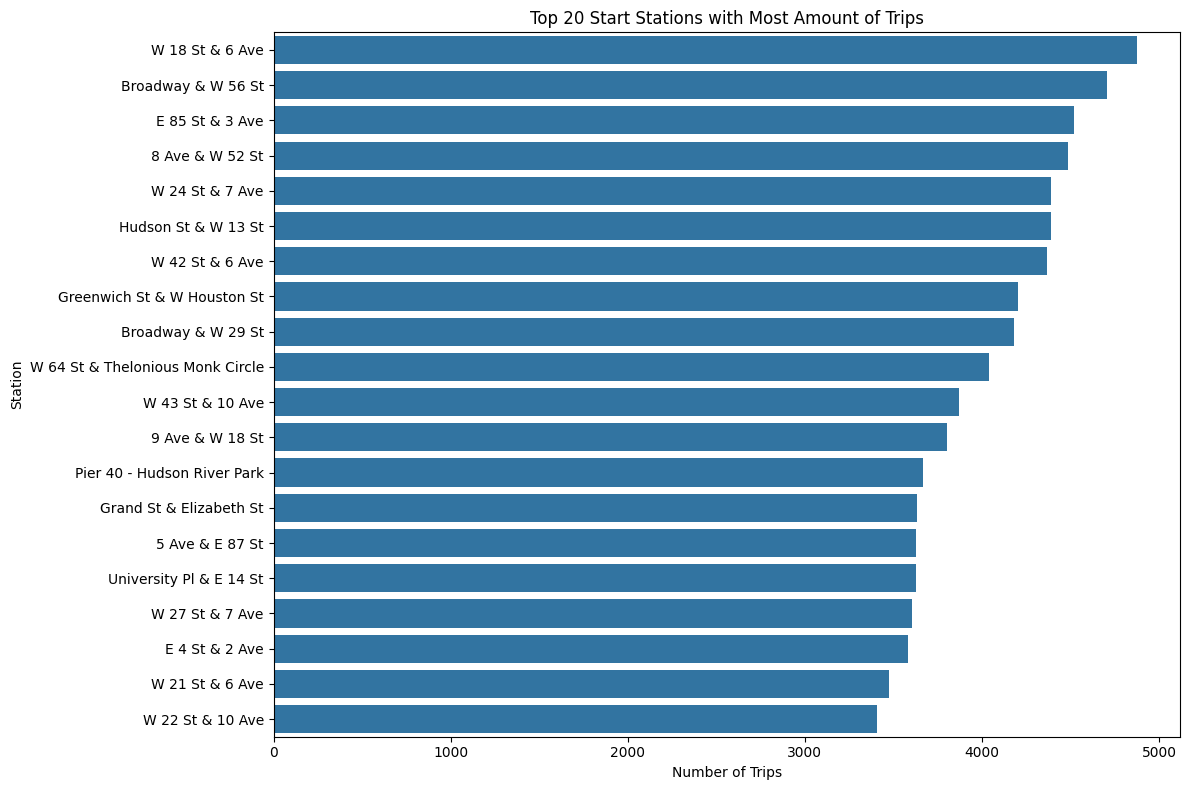

In [15]:
# Create top 20 start station DataFrame
top_20_df = df_filtered['start_station_name'].value_counts().head(20).reset_index()
top_20_df.columns = ['Station', 'Trip Count']


plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_df, x='Trip Count', y='Station')
plt.title('Top 20 Start Stations with Most Amount of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


I then used a line plot to show how trip volume fluctuates throughout the day, helping identify peak demand hours. This hourly pattern complements our station-level analysis by adding a temporal dimension to the prediction of which stations are likely to be busiest and when.

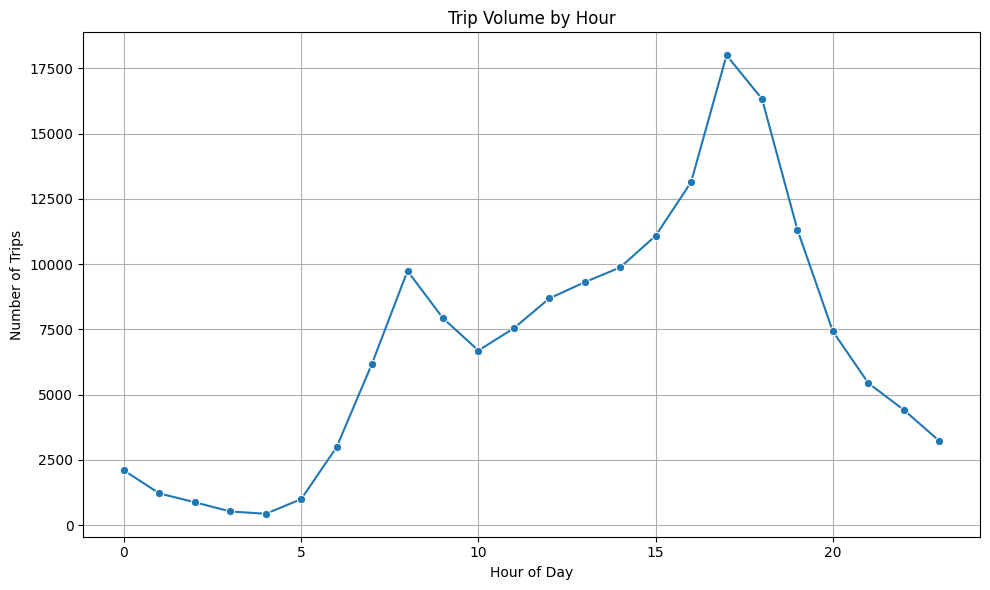

In [16]:
hourly_counts = df_filtered['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o')
plt.title('Trip Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.tight_layout()
plt.savefig('trip_volume_by_hour_saturday.png')
plt.show()


This scatterplot illustrates the relationship between trip duration and time of day, helping understand when riders tend to take longer or shorter rides. By filtering out extreme outliers, we can observe that most rides are clustered below 1,000 seconds (around 15–20 minutes), with occasional longer trips throughout the day.

<ipython-input-17-8f54618b1d94>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_filtered['end_time'] = pd.to_datetime(df_filtered['end_time'], errors='coerce')


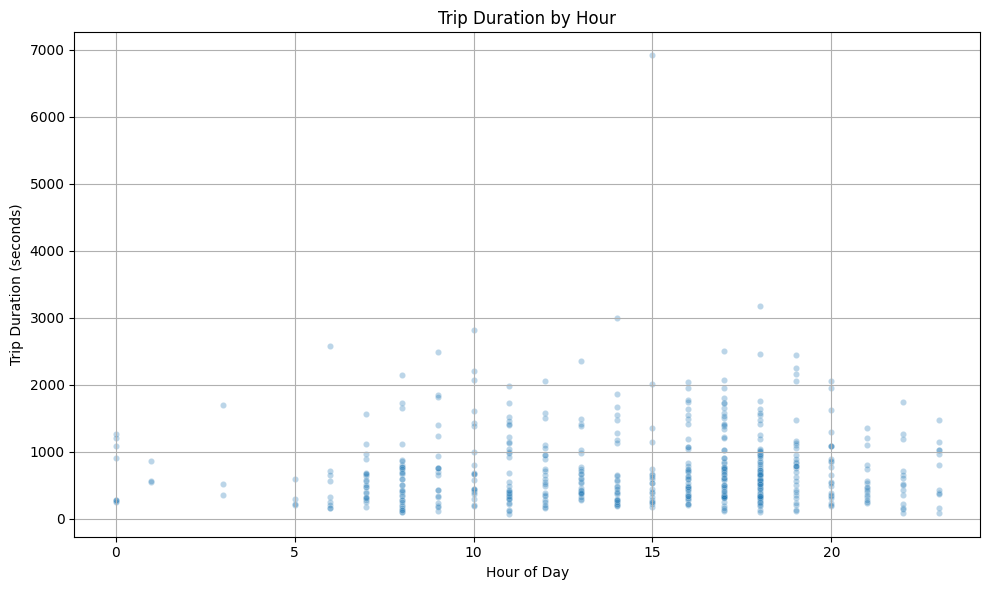

In [17]:
# Convert times
df_filtered['start_time'] = pd.to_datetime(df_filtered['start_time'], errors='coerce')
df_filtered['end_time'] = pd.to_datetime(df_filtered['end_time'], errors='coerce')

# Create trip duration in seconds
df_filtered['tripduration'] = (df_filtered['end_time'] - df_filtered['start_time']).dt.total_seconds()

# Keep only valid durations  (0 < duration < 7200 seconds = 2 hours)
df_valid = df_filtered[(df_filtered['tripduration'] > 0) & (df_filtered['tripduration'] < 7200)]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_valid.sample(500), x='hour', y='tripduration', alpha=0.3, s=20)
plt.title('Trip Duration by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Duration (seconds)')
plt.grid(True)
plt.tight_layout()
plt.savefig('tripduration_by_hour_scatter_cleaned.png')
plt.show()


This graph displays the Top 15 End Stations, providing insight into where Citi Bike riders most frequently conclude their trips. Analyzing end-station popularity complements the understanding of start-station demand and helps identify high-traffic drop-off locations, which are crucial for planning rebalancing efforts and docking station capacity. By pairing this with start station and time-of-day data, we can build a more complete picture of bike flow patterns.

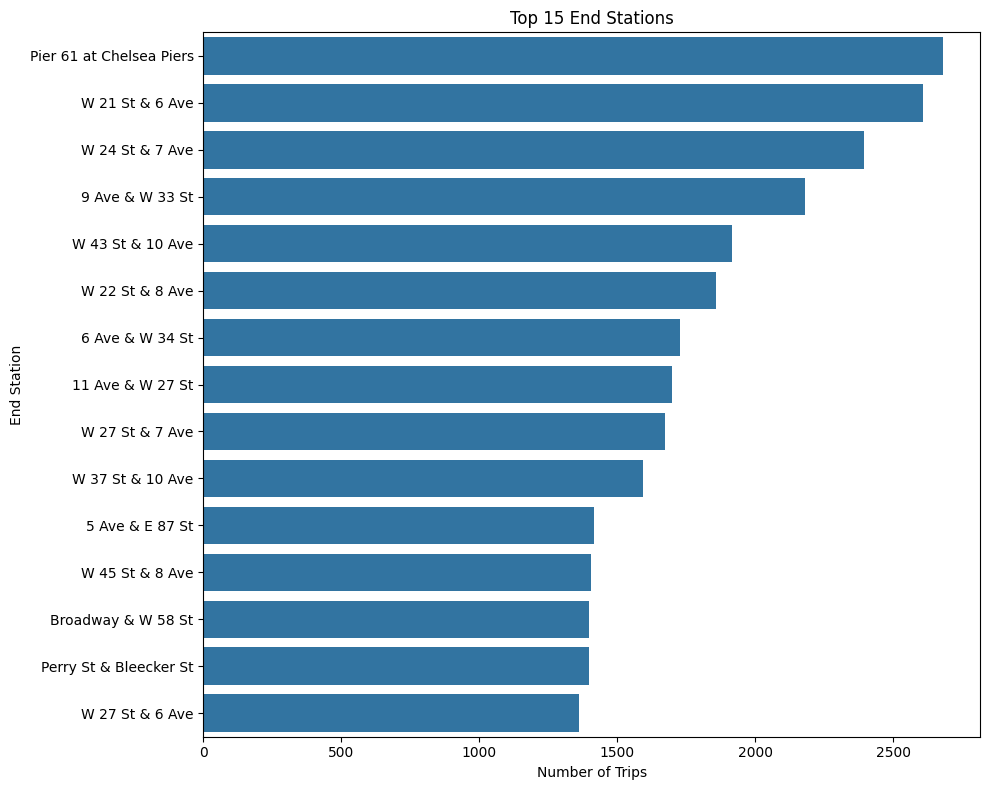

In [18]:
top_end_stations = df_filtered['end_station_name'].value_counts().head(15)

plt.figure(figsize=(10, 8))
sns.barplot(y=top_end_stations.index, x=top_end_stations.values)
plt.title('Top 15 End Stations')
plt.xlabel('Number of Trips')
plt.ylabel('End Station')
plt.tight_layout()
plt.show()


To predict, station-level trip volume, I applied one-hot encoding to the categorical variables—such as station names and time attributes—to prepare the data for modeling. Using this transformed dataset, I implemented a linear regression model, splitting the data into an 80% training set and a 20% testing set. This allowed me to train the model on historical patterns while preserving a portion of the data to evaluate its predictive performance. By comparing predicted trip counts against actual counts, I was able to assess the model’s accuracy and its ability to generalize to unseen combinations of time and location. The model achieved a Root Mean Squared Error of 93.59 and an R² score of 0.23, meaning that while it was able to capture some patterns in the data, it explained only 23% of the variation in trip counts across station-hour combinations. This modest performance suggests that while station identity and time-based features provide useful signals, they are not sufficient to fully account for the variability in trip volume. Incorporating additional data such as historical demand trends could significantly enhance the model’s ability to predict which stations will be busiest.

RMSE: 93.59
R²: 0.23


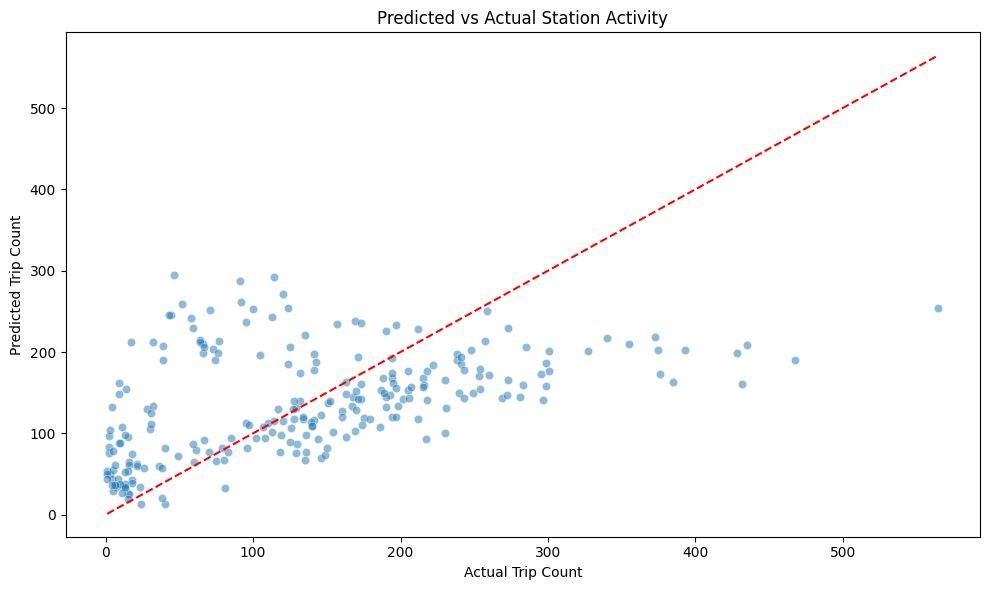

In [19]:

agg_df = df_filtered.groupby(['start_station_name', 'hour', 'day_of_week', 'month']) \
                    .size().reset_index(name='trip_count')

# One-hot encode categorical variables
agg_encoded = pd.get_dummies(agg_df, columns=['start_station_name', 'day_of_week', 'month'], drop_first=True)

X = agg_encoded.drop(columns=['trip_count'])
y = agg_encoded['trip_count']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# prediction vs actual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Predicted vs Actual Station Activity')
plt.tight_layout()
plt.show()



This graph shows the top 15 most predictive features in the linear regression model used to estimate station-level trip volume. The feature with the highest coefficient is Broadway & W 56 St, indicating that this station contributes the most to predicting a higher trip count. Other highly predictive stations include W 18 St & 6 Ave, Hudson St & W 13 St, and W 24 St & 7 Ave, suggesting these locations are consistently associated with higher bike activity on Saturday. The coefficients represent how much each station increases the predicted number of trips, holding other factors constant. This visualization directly informs which stations are driving the model’s predictions and highlights key areas of rider demand.

<ipython-input-20-08521f0e9497>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='viridis')


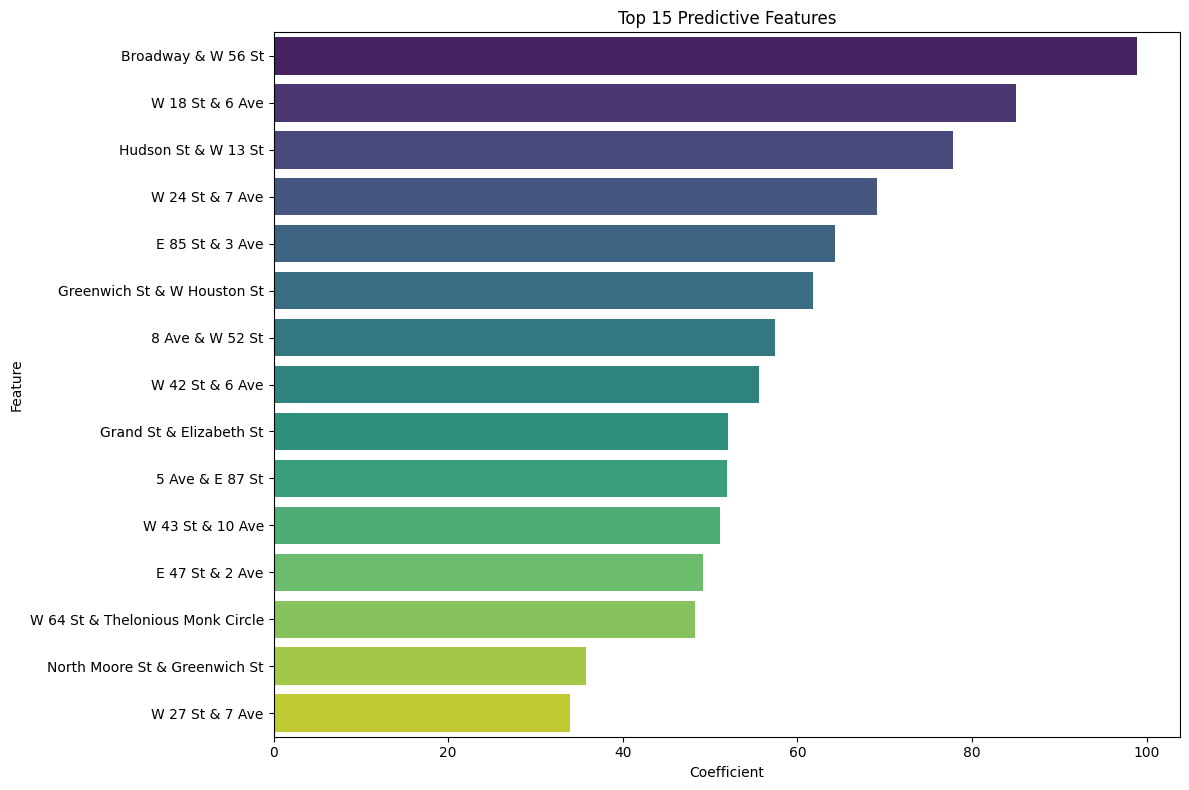

In [20]:
# Create DataFrame with feature names and coefficients
coefs_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

# Clean up feature names
coefs_df['Feature'] = coefs_df['Feature'].str.replace('start_station_name_', '', regex=False)

# Get top 15 features by absolute value
top_features = coefs_df.reindex(coefs_df.Coefficient.abs().sort_values(ascending=False).index).head(15)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='viridis')
plt.title('Top 15 Predictive Features')
plt.tight_layout()
plt.savefig('feature_importance_cleaned.png')
plt.show()


After using simple linear regression, I wanted to try KNN regression to better capture non-linear relationships in the data. Linear regression assumes a straight-line relationship between features and trip volume, which can oversimplify patterns, especially with something as dynamic as Citi Bike usage across different stations and times. KNN, on the other hand, predicts trip volume by finding the most similar past station-time combinations and averaging their outcomes. This makes it more flexible and responsive to local patterns in the data.

The results confirmed this: KNN significantly outperformed linear regression, with a lower RMSE and much higher R² score (0.84 vs. 0.23). This shows that station-level trip volume depends heavily on context and pattern repetition, and that models like KNN, which rely on historical similarity, are better suited.

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODEL 1: KNN REGRESSION
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)

rmse_knn = np.sqrt(mean_squared_error(y_test, y_knn_pred))
r2_knn = r2_score(y_test, y_knn_pred)

print(f"KNN RMSE: {rmse_knn:.2f}")
print(f"KNN R²: {r2_knn:.2f}")

# MODEL 2: DECISION TREE REGRESSION
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test)

rmse_tree = np.sqrt(mean_squared_error(y_test, y_tree_pred))
r2_tree = r2_score(y_test, y_tree_pred)

print(f"Decision Tree RMSE: {rmse_tree:.2f}")
print(f"Decision Tree R²: {r2_tree:.2f}")


KNN RMSE: 42.59
KNN R²: 0.84
Decision Tree RMSE: 53.30
Decision Tree R²: 0.75


These two scatterplots compare the predicted trip counts to the actual trip counts for the KNN and Decision Tree models. I created these plots to visually assess how well each model performed in predicting station-level trip volume on the test set.

In the top plot, the KNN model shows a strong clustering of points along the red diagonal line which represents perfect prediction. This means the KNN model was able to closely match predicted trip counts to actual counts, with only small deviations, especially in the low to mid trip ranges. This aligns with its high R² score (0.84) and low RMSE (42.59), showing that it consistently captures variation in station activity based on historical similarity.

I used a Decision Tree model to explore a more rule-based approach to predicting station-level trip volume. Decision trees split the data into segments based on specific thresholds, like hour or station, that best reduce prediction error.

By setting a maximum depth of 5, I limited the complexity to avoid overfitting while still allowing the model to learn meaningful patterns. The tree performed well, with an RMSE of 53.30 and an R² of 0.75, showing that it was able to learn decision rules that explain most of the variation in trip volume.

The Decision Tree model shows more scattered predictions and less alignment with the diagonal line, especially in higher trip volumes. While it still performs reasonably well R² = 0.75, the tree model tends to make more blunt, less flexible predictions due to its limited depth. This visualization helped me confirm that while both models outperform linear regression, KNN is more precise and better suited for capturing the structure of the data in this case

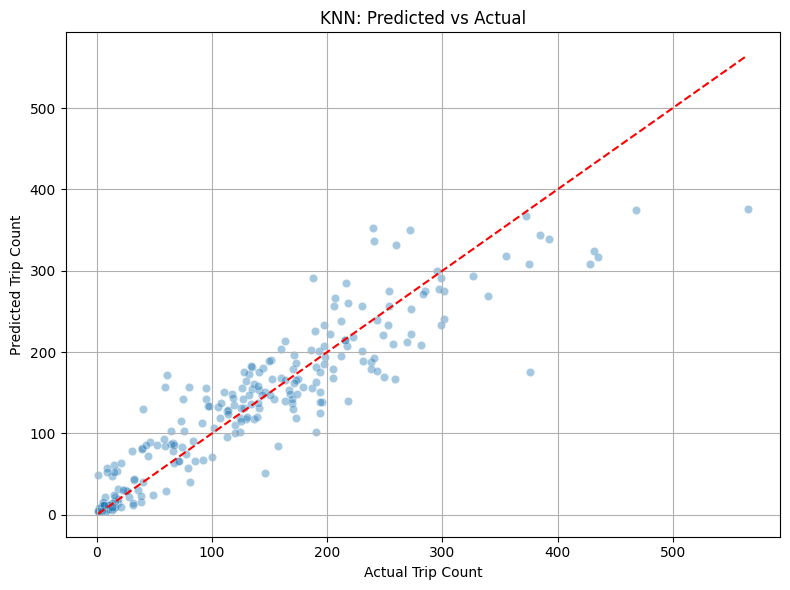

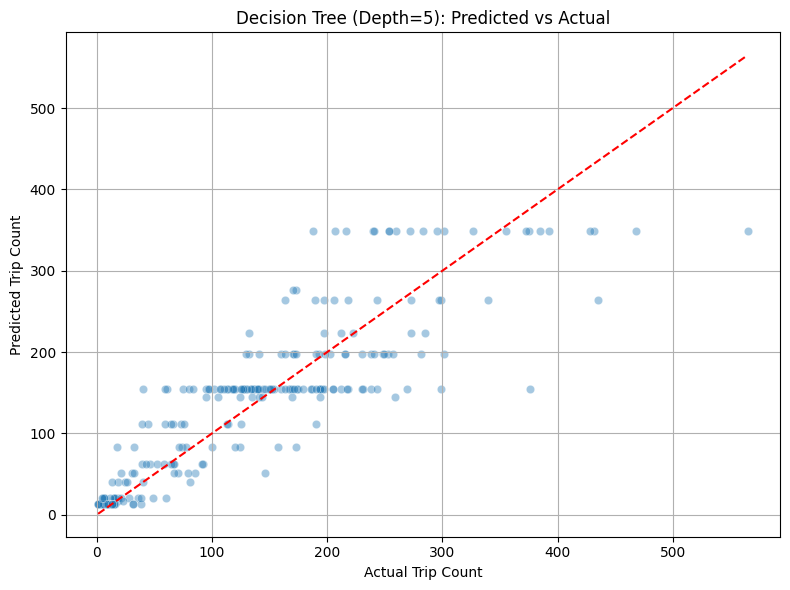

In [22]:

def plot_predictions(y_true, y_pred, title, filename):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(title)
    plt.xlabel('Actual Trip Count')
    plt.ylabel('Predicted Trip Count')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_predictions(y_test, y_knn_pred, "KNN: Predicted vs Actual", "knn_pred_vs_actual.png")
plot_predictions(y_test, y_tree_pred, "Decision Tree (Depth=5): Predicted vs Actual", "tree_pred_vs_actual.png")


In this part of the analysis, I used my trained KNN regression model to predict which Citi Bike stations will be the busiest during each hour of the day on the upcoming Saturday. Unlike the earlier chart that showed the top stations by total trip volume, this approach breaks it down by hour, revealing how rider demand shifts throughout the day. To do this, I created a dataset combining the top 50 stations with each hour from 0 to 23, encoded the features to match the model's training format, and ran predictions using the KNN model. For each hour, I selected the station with the highest predicted trip count.

This analysis differs from the original “busiest stations” chart because it highlights when each station is expected to be busiest, not just which stations have the highest overall traffic. For example, while Broadway & W 56 St and W 18 St & 6 Ave remain among the top stations overall, the hour-by-hour predictions show that Hudson St & W 13 St is expected to be busiest in the early morning hours, while W 64 St & Thelonious Monk Circle and Greenwich St & W Houston St take the lead during midday and afternoon periods. This hourly view provides deeper operational insight, showing that even stations with lower total volume may experience peak traffic during specific times, which wouldn’t be visible in the original aggregate analysis.

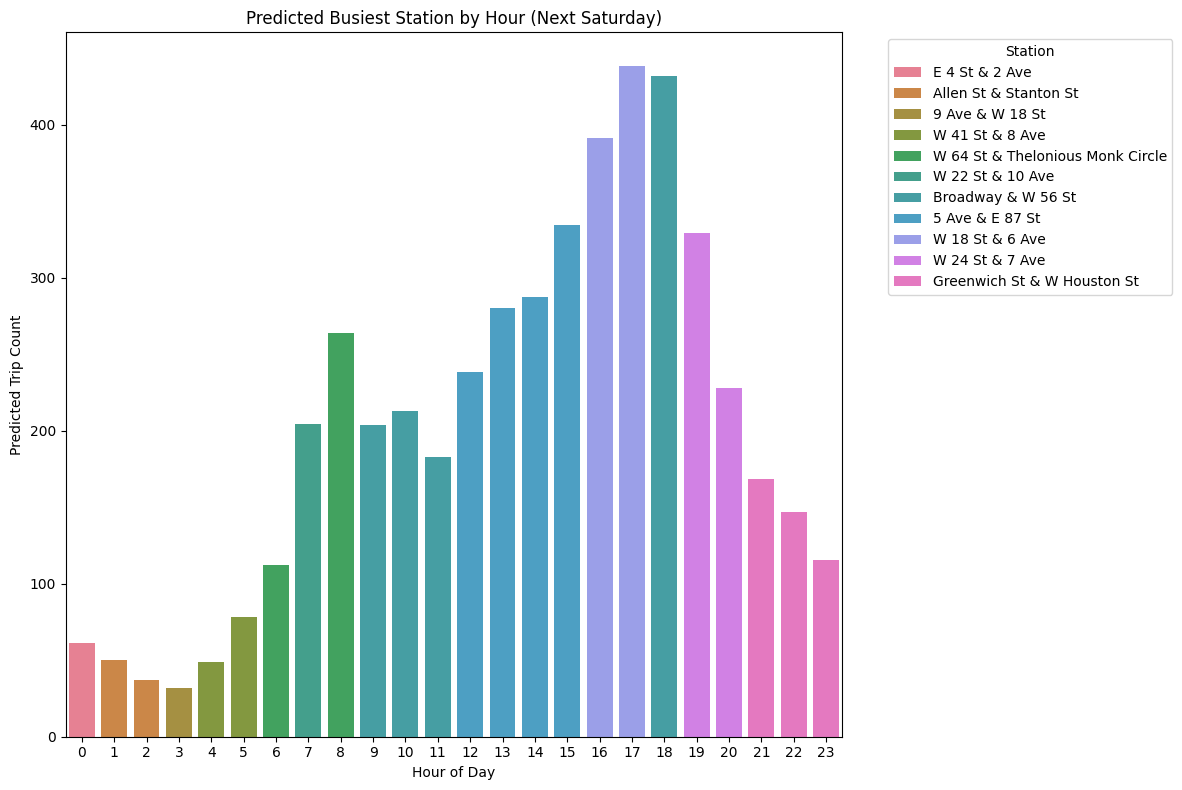

,hour,start_station_name,predicted_trip_count
408,0,E 4 St & 2 Ave,61.2
745,1,Allen St & Stanton St,50.2
746,2,Allen St & Stanton St,37.2
267,3,9 Ave & W 18 St,31.6
772,4,W 41 St & 8 Ave,49.0
773,5,W 41 St & 8 Ave,78.4
222,6,W 64 St & Thelonious Monk Circle,112.0
463,7,W 22 St & 10 Ave,204.4
224,8,W 64 St & Thelonious Monk Circle,263.8
33,9,Broadway & W 56 St,203.6


In [23]:

top_stations = df_filtered['start_station_name'].value_counts().head(50).index
saturday_hours = list(range(24))

# Build prediction input: all station-hour combinations
future_df = pd.DataFrame([(station, hour, 'Saturday', 'May') for station in top_stations for hour in saturday_hours],
                         columns=['start_station_name', 'hour', 'day_of_week', 'month'])

# One-hot encode future data
future_encoded = pd.get_dummies(future_df, columns=['start_station_name', 'day_of_week', 'month'], drop_first=True)

# Align with training columns
missing_cols = set(X.columns) - set(future_encoded.columns)
for col in missing_cols:
    future_encoded[col] = 0
future_encoded = future_encoded[X.columns]

# Predict using your trained model (e.g., KNN)
future_df['predicted_trip_count'] = knn.predict(future_encoded)

# Find busiest station per hour
busiest_per_hour = future_df.loc[future_df.groupby('hour')['predicted_trip_count'].idxmax()]

plt.figure(figsize=(12, 8))
sns.barplot(data=busiest_per_hour, x='hour', y='predicted_trip_count', hue='start_station_name')
plt.title('Predicted Busiest Station by Hour (Next Saturday)')
plt.xlabel('Hour of Day')
plt.ylabel('Predicted Trip Count')
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('busiest_station_per_hour_next_saturday.png')
plt.show()

busiest_per_hour[['hour', 'start_station_name', 'predicted_trip_count']]


## Next Steps & Discussion

# Key Findings

In my analysis of station-level Citi Bike trip volume, I tested KNN Regression, Decision Tree Regression, and Linear Regression to predict how busy each station would be based on time and location features.  Among them, KNN regression delivered the best performance, accurately capturing repeated patterns in ridership behavior across station-hour combinations.

The KNN model was the most effective, achieving an RMSE of 42.59 and an R² of 0.84. It was especially successful at identifying patterns based on the similarity of station and time combinations, especially since past behavior can be a reliable indicator of future rides.

Features like hour of day were consistently among the most predictive across all models, highlighting the cyclical nature of bike-share demand. While location was important, the timing of trips played a stronger role in predicting volume.

More flexible models like KNN and decision trees performed significantly better than linear regression, indicating that trip volume patterns are not linear and depend on complex interactions between station, time, and possibly other unseen factors.

Using the trained KNN model, I predicted which stations would be busiest for each hour on the upcoming Saturday. This added a temporal layer to the analysis, revealing not just where demand is high, but when each station peaks.


# Next Steps

To improve prediction accuracy and capture even more relevant real-world variation, I would consider incorporating the following enhancements in future models

Proximity to parks or subways:
I think it would be interesting to add features related to a station’s surroundings, such as its distance to major transit hubs, commercial areas, or green spaces, which could help explain why some stations experience consistently higher demand

More Historical Data:
I only used one Saturday’s data due to the large amount of data rows but I think it would be more accurate of a model to be able to use multiple Saturdays to be able to get a more holistic picture to predict.

Weather Data:
Integrating temperature, precipitation, and wind conditions would help account for fluctuations in ridership due to changing weather

These improvements would allow for more detailed and context-aware predictions.